# Clean and analyse tweets
The purpose for this notebook is to provide a body of cleaned and enriched tweets that can be used in our downstream analytical processes. In particular, we want to remove tweets that are not relevant to our research and we want to enrich relevant tweets with cleaned message text, hashtags employed and people the tweet interacts with (replies, retweets and mentions).
- The identification the most significant hashtags is an important outcome from this notebook as these hashtags will be used as seeds for creating the hashtag cooccurrance networks in later steps.

The specific steps performed are described below.

## 1. Load previously fetched Twitter data
Load the multiple extract files created over a month of downloading twitter data using predefined search terms.

## 2. Clean twitter data
High level cleaning of Twitter data which will entail: 
- removing duplicates
- removing NaN values
- removing tweets that don't contain meaningful text
- stripping out special symbols (line breaks, html, ampersands ..) from Tweet message text

## 3. Enrich the dataset with derived features to aid exploratory analysis
This research is investigating conversations about serious violent crime and so we want to understand how it is being discussed within our body of tweets. 
We also want to identify tweets that aren't relevant so we can remove them. To do this we need to enrich our dataset in preparation for this analysis and 
the key steps we perform are as follows:
- extract retweets, mentions and hashtags from the twitter message text
- clean the message text: strip out punctuation, URL links
- tokenize and lemmatize the text - we convert the message text to individual words and then strip out stop words and reduce different variants of the same word to their single base form (lemmatize)

The output of this section is a twitter dataset enriched with features plus also the identification of the most popular hashtags, mentions and retweets

## 4. Analyse and prune Twitter data
Having enriched the dataset, we can now analyse the data using visualisations fed with our preprocessed and enriched data. 
The specific visualisations we use are as follows:
- Correlation matrices to see which hashtags correlate most highly
- Treemaps to visualize most popular hashtags, mentions and retweets
- Word clouds to visualise most commonly occuring words and hashtags
- bar charts to visualise the most commonly occuring words and phrases (bigrams and trigrams)

We will then use these visualisations to identify words, hashtags, people that aren't relevant for our research. We will then prune these tweets from our datasets and assess the results. When we are happy that we have pruned all irrelevant tweets we will progress to the next step, which is to review high level statistics for our data

## 5. Analyse general statistics
Now we want to find out some general statistics about our dataset. These include:
- Number of tweets and number of unique users
- Where tweets originated
- Tweet volumes over time

## 6. Produce extract file
This is the final step and creates a csv with pruned and enriched tweets for use in downstream analytical processes.

## Notes:
The code used in this notebook draws heavily on cleaning code I produced previously for Visual Analytics coursework, which in turn was inspired by https://ourcodingclub.github.io/tutorials/topic-modelling-python/

In [1]:
import os
import tweepy
import datetime
import pandas as pd
import numpy as np
from glob import glob

## 1. Load previously fetched Twitter data
We repeatedly extracted Twitter data using the notebook 1_6 Get Tweets and we accumulated approximately 70,000 tweets, spanning the period 20th July 2021 to 25th August 2021. We ran the extracts on a weekly basis and each run exported the collected tweets into a .csv file prefixed with the date the extract was run. We now load these files.
- We need to load multiple files and merge them into a single dataframe - the following code is inspired by https://towardsdatascience.com/6-pandas-tricks-you-should-know-to-speed-up-your-data-analysis-d3dec7c29e5

In [2]:
files = sorted(glob("./DataSources/TwitterData/raw_tweets_*.csv"))
files

['./DataSources/TwitterData\\raw_tweets_20210728.csv',
 './DataSources/TwitterData\\raw_tweets_20210729.csv',
 './DataSources/TwitterData\\raw_tweets_20210730.csv',
 './DataSources/TwitterData\\raw_tweets_20210805.csv',
 './DataSources/TwitterData\\raw_tweets_20210806.csv',
 './DataSources/TwitterData\\raw_tweets_20210812.csv',
 './DataSources/TwitterData\\raw_tweets_20210820.csv',
 './DataSources/TwitterData\\raw_tweets_20210821.csv',
 './DataSources/TwitterData\\raw_tweets_20210825.csv']

In [3]:
all_tweets_raw = pd.concat(pd.read_csv(file) for file in files)
print("Number of rows loaded: {:,}, number of columns: {}".format(all_tweets_raw.shape[0],
                                                               all_tweets_raw.shape[1]))

print("earliest tweet date: {}, latest tweet date: {}".format(all_tweets_raw.tweet_date.min(),
                                                              all_tweets_raw.tweet_date.max()))
display(all_tweets_raw.head())
display(all_tweets_raw.tail())

Number of rows loaded: 70,013, number of columns: 14
earliest tweet date: 2021-07-20 05:03:35, latest tweet date: 2021-08-26 15:09:51


,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,tweeter_coordinates,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,NaN,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,20210728,London AND knife AND crime
2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime
3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,NaN,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime


,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,tweeter_coordinates,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
7073,1427990765075111940,2021-08-18 13:48:23,1029077250,C/Supt Martin Fry,BTPFry,London,NaN,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,20210826,London AND stabbing
7074,1427990764668264453,2021-08-18 13:48:23,809535258970488832,Beds & Bucks RSC,BedsBucksRSC,Bedfordshire & Buckinghamshire,NaN,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,20210826,London AND stabbing
7075,1427990548984602632,2021-08-18 13:47:32,607561907,Chris Brown,chr1saybrown,Gosport,NaN,RT @BTPLondon: Do you recognise these men?\n\n...,NaN,NaN,0,198,20210826,London AND stabbing
7076,1427990527920812035,2021-08-18 13:47:27,957226980,BTP London,BTPLondon,"London, England",NaN,Do you recognise these men?\n\nOfficers want t...,NaN,NaN,90,198,20210826,London AND stabbing
7077,1427990490629222401,2021-08-18 13:47:18,1244696425952354304,The Borough of Hounslow Herald,hounslowherald,"Hounslow, London",NaN,Officers investigating a stabbing at West Indi...,NaN,NaN,0,0,20210826,London AND stabbing


## 2. Clean twitter data

#### 2.1. Remove duplicates
We are loading data from multiple files and based on multiple search terms and so this means a single tweet might be duplicated multiple times. Therefore, we remove duplicates based on tweet_id, which is a unique identifier
- Each object within Twitter - a Tweet, Direct Message, User, List, and so on - has a unique ID (https://developer.twitter.com/en/docs/twitter-ids)

In [4]:
pre_row_count = all_tweets_raw.shape[0]

all_tweets = all_tweets_raw.drop_duplicates(subset=['tweet_id']).reset_index()
post_row_count = all_tweets.shape[0]

print("Number of rows before removing duplications: {:,}, and number of rows after: {:,}".format(pre_row_count, post_row_count))
all_tweets.head()

Number of rows before removing duplications: 70,013, and number of rows after: 52,201


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,tweeter_coordinates,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,NaN,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,20210728,London AND knife AND crime
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,NaN,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,20210728,London AND knife AND crime
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,NaN,NaN,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,20210728,London AND knife AND crime


#### 2.2. Remove NaN values

In [5]:
all_tweets = all_tweets.dropna(how='all') # only drops a row when every column is NA

all_tweets.shape

(52201, 15)

In [6]:
# Now check for individual NaN values
nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())

index                           52201
tweet_id                        52201
tweet_date                      52201
tweeter_id                      52201
tweeter_user_name               52198
tweeter_screen_name             52201
tweeter_location                34482
tweeter_coordinates                 4
message_text                    52201
in_reply_to_user_screen_name     4691
quote_tweet_screen_name           822
favourite_count                 52201
retweet_count                   52201
extract_run_date                52201
retrieved_using_search_term     52201
dtype: int64


##### Comments
- tweeter_coordinates is nearly always NaN so drop it
- tweeter_location is often NaN so set it to "unknown" when it is NaN
- it's OK if in_reply_to_user_screen_name = Nan, just set to blanks
- it's OK if quote_tweet_screen_name = Nan, just set to blanks

In [7]:
all_tweets.drop('tweeter_coordinates', axis=1, inplace=True)

all_tweets.loc[all_tweets['tweeter_location'].isna(), 'tweeter_location'] = 'unknown'
all_tweets.loc[all_tweets['in_reply_to_user_screen_name'].isna(), 'in_reply_to_user_screen_name'] = ''
all_tweets.loc[all_tweets['quote_tweet_screen_name'].isna(), 'quote_tweet_screen_name'] = ''

nan_values = all_tweets[all_tweets.isna().any(axis=1)]
print(nan_values.count())
nan_values.head()

index                           3
tweet_id                        3
tweet_date                      3
tweeter_id                      3
tweeter_user_name               0
tweeter_screen_name             3
tweeter_location                3
message_text                    3
in_reply_to_user_screen_name    3
quote_tweet_screen_name         3
favourite_count                 3
retweet_count                   3
extract_run_date                3
retrieved_using_search_term     3
dtype: int64


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,extract_run_date,retrieved_using_search_term
10855,1743,1420847689441419278,2021-07-29 20:44:21,996022000605855744,NaN,SMorris48073327,unknown,RT @GoodLawProject: Government used public mon...,,,0,1198,20210730,sadiq AND khan
14558,5466,1420680783296176134,2021-07-29 09:41:08,996022000605855744,NaN,SMorris48073327,unknown,RT @GoodLawProject: BREAKING: New emails revea...,,,0,4299,20210730,sadiq AND khan
33581,2904,1425434707311808513,2021-08-11 12:31:32,404712562,NaN,tweeter77777777,Occupying stolen Nuenonne Land,RT @WilkieMP: The continuing attempts by the U...,,,0,548,20210812,London AND crime


##### Comments - round 2
- Don't worry about rows where tweeter_user_name is NaN because we use the tweeter_screen_name rather than tweeter_user_name
- No other columns with nulls

#### 2.3. Remove tweets that don't contain meaningful text
I define meaningful as containing more than 4 characters.
- Also remove rows where message text comprises up to 15 blanks

In [8]:
all_tweets = all_tweets[all_tweets['message_text'].str.len() > 4]

print(all_tweets.shape)

(52201, 14)


In [9]:
all_tweets['message_text'] = all_tweets['message_text'].fillna('')
all_tweets['message_text'].replace('', np.nan, inplace=True)
all_tweets['message_text'].replace(' ', np.nan, inplace=True)
all_tweets['message_text'].replace('   ', np.nan, inplace=True)
all_tweets['message_text'].replace('    ', np.nan, inplace=True)
all_tweets['message_text'].replace('     ', np.nan, inplace=True)
all_tweets['message_text'].replace('      ', np.nan, inplace=True)
all_tweets['message_text'].replace('       ', np.nan, inplace=True)
all_tweets['message_text'].replace('        ', np.nan, inplace=True)
all_tweets['message_text'].replace('         ', np.nan, inplace=True)
all_tweets['message_text'].replace('          ', np.nan, inplace=True)
all_tweets['message_text'].replace('           ', np.nan, inplace=True)
all_tweets['message_text'].replace('            ', np.nan, inplace=True)
all_tweets['message_text'].replace('             ', np.nan, inplace=True)
all_tweets['message_text'].replace('              ', np.nan, inplace=True)
all_tweets['message_text'].replace('               ', np.nan, inplace=True)
all_tweets['message_text'].replace('                ', np.nan, inplace=True)
all_tweets['message_text'].replace('                 ', np.nan, inplace=True)
all_tweets['message_text'].replace('                  ', np.nan, inplace=True)
all_tweets['message_text'].replace('                   ', np.nan, inplace=True)
all_tweets['message_text'].replace('                    ', np.nan, inplace=True)
all_tweets['message_text'].replace('                     ', np.nan, inplace=True)
all_tweets['message_text'].replace('                              ', np.nan, inplace=True)
all_tweets['message_text'].replace('                                                                        ', np.nan, inplace=True)
all_tweets['message_text'].replace('                                                                                                                     ', np.nan, inplace=True)

all_tweets.dropna(subset=['message_text'], inplace=True)

print(all_tweets.shape)

(52201, 14)


#### 2.4. Strip out noise from Tweet message text
We first want to strip out special symbols from the code such as line breaks, html links, ampersands, less than and greater than symbols.  
- This code was taken from Visual Analytics_Lab08 (Text processing)

In [10]:
def preprocess(message_text):
    message_text = message_text.str.replace("(<br/>)", "")
    message_text = message_text.str.replace('(<a).*(>).*(</a>)', '')
    message_text = message_text.str.replace('(&amp)', '')
    message_text = message_text.str.replace('(&gt)', '')
    message_text = message_text.str.replace('(&lt)', '')
    message_text = message_text.str.replace('(\xa0)', ' ')  
    return message_text


all_tweets['message_text'] = preprocess(all_tweets['message_text'])

### 2.5. Cleaning Comments
We removed nearly 20,000 duplicates and we now have a dataframe with unique tweets, without NaN valuesand with noise removed from within the Twitter message text. The next step is to enrich/transform our data 

## 3. Enrich the dataset with derived features to aid exploratory analysis
The key steps we perform to clean and enrich our dataset are as follows:
- extract retweets, mentions and hashtags from the twitter message text
- clean the message text: strip out punctuation, URL links
- tokenize and lemmatize the text - we convert the message text to individual words and then strip out stop words and reduce different variants of the same word to their single base form (lemmatize)

The output of this section is a twitter dataset enriched with features plus also the identification of the most popular hashtags, mentions and retweets
- We will then visualise analyse these features in the next step

- This code draws heavily from the coursework submitted for Visual Analytics, which in turn was inspired by https://ourcodingclub.github.io/tutorials/topic-modelling-python/

First we define the functions we will use to enrich the data (3.1) and then we execute those functions (3.2)

### 3.1. Functions that will be used to enrich Twitter data

#### 3.1.1 Functions for deriving who was retweeted, mentioned or which hashtags were used

In [11]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())   

def get_rt_mentions_hash(df, col_name):
    df['retweeted'] = df[col_name].apply(find_retweeted)
    df['mentioned'] = df[col_name].apply(find_mentioned)
    
    df['hashtags'] = df[col_name].apply(find_hashtags)
    
    return df

#### 3.1.2 Functions to prepare data for wordclouds, NGRAMs
The raw message text contains superflous punctuation, links and URLs that we want to remove from the text as it's not useful for downstream processing. In addition, we want to tokenize the text into its individual words such that we can first remove stopwords, namely common words and connectors that don't add meaning, and also to lemmatize the words. Lemmatization is the process of reducing multiple different forms of a word to a single base variant as removing what is effectively duplication is helpful for downstream analysis in terms of both computational effort and also removing unnecessary features that could lead to model overfitting.

The resulting features and clean message text are appended to each tweet.
- This code was based on coursework submitted for VisualAnalytics

In [12]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')

def remove_links(text):
    '''Takes a string and removes web links from it'''
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    return text

def remove_users(text):
    '''Takes a string and removes retweet and @user information'''
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove tweeted at
    return text

def remove_punct(text):
    text = remove_users(text)
    text = remove_links(text)
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def tokenization(text):
    text = word_tokenize(text)
    return text

def remove_stopwords(text):
    stop_words = (stopwords.words('english'))
    stop_words.extend(['a','all','and','but','come','could','day','even',
             'he','it','if','i','on','like','man','made','men','must',
             'one','see','she','said','say','sort',
             'still','the','that','to','they','this','then','there',
             'would','two','what','you','-','_','—','***','rt', 'via','http',
             'London','london','xxx','xx','bong','got',
             'seen', 'sure', 'dont','gon','na','wan', 'uk',
             'united kingdom','britain','ffs','british','un','hahaha','haha','hahahaha','britains'])  
    
    text = [w for w in text if not w in stop_words]
    return text

def lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w, pos='a') for w in text]
    return text

def recreate_tweet(word_list):
    tweet = ' '.join([w for w in word_list])
    return tweet
    
def get_hashtags(tweet):
    hash_tags= [i  for i in tweet.split() if i.startswith("#") ]
    return " ".join(hash_tags)

def get_clean_lemmatized(df, col_name):
    df['Tweet_punct'] = df[col_name].apply(lambda x: remove_punct(x))
    df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
    df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
    df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
    df['Clean_MessageText'] = df['Tweet_lemmatized'].apply(lambda x: recreate_tweet(x))
    
    # create a single text string for all hash tags and for all clean text
    hash_tags = get_hashtags(" ".join(ttext for ttext in df[col_name]))
    all_clean_words = " ".join(ttext for ttext in df['Clean_MessageText']) # code taken from VA_Lab08 (Text)
    
    return df, hash_tags, all_clean_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 3.1.3 Helper functions for Correlation, Treemap and Wordcloud plots

##### 3.1.3.1 Get popular hashtags
THis includes functions to derive correlations between hashtags # Code very gratefully borrowed from 
https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

In [13]:
# take the rows from the hashtag columns where there are actually hashtags
def get_popular_hashtags(df, min_appearance):
    hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

    # create dataframe where each use of hashtag gets its own row
    flattened_hashtags_df = pd.DataFrame(
        [hashtag for hashtags_list in hashtags_list_df.hashtags
        for hashtag in hashtags_list],
        columns=['hashtag'])

    # count of appearances of each hashtag
    popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    # now create a matrix of popular hashtags so we can see how they correlate
    popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

    # make a new column with only the popular hashtags
    hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
    # drop rows without popular hashtag
    popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

    # make new dataframe
    hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

    for hashtag in popular_hashtags_set:
        # make columns to encode presence of hashtags
        hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
            lambda hashtag_list: int(hashtag in hashtag_list))
    
    # Now satisfied we will drop the popular_hashtags column from the dataframe. We don’t need it.
    hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
    
    return popular_hashtags, hashtag_matrix


# Code very gratefully borrowed from 
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

##### 3.1.3.2 Get popular retweeted
Similar code to above
- take the rows from the hashtag columns where there are actually hashtags

In [14]:
def get_popular_retweets(df):
    retweeted_list_df = df.loc[
                       df.retweeted.apply(
                           lambda retweeted_list_df: retweeted_list_df !=[]
                       ),['retweeted']]

    # create dataframe where each use of hashtag gets its own row
    flattened_retweeted_df = pd.DataFrame(
        [retweeted for retweeted_list in retweeted_list_df.retweeted
        for retweeted in retweeted_list],
        columns=['retweeted'])

    # count of appearances of each hashtag
    popular_retweeted = flattened_retweeted_df.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    return popular_retweeted

##### 3.1.3.3 Get popular mentions

In [15]:
def get_popular_mentioned(df):
    mentioned_list_df = df.loc[
                       df.mentioned.apply(
                           lambda mentioned_list_df: mentioned_list_df !=[]
                       ),['mentioned']]

    # create dataframe where each use of hashtag gets its own row
    flattened_mentioned_df = pd.DataFrame(
        [mentioned for mentioned_list in mentioned_list_df.mentioned
        for mentioned in mentioned_list],
        columns=['mentioned'])

    # count of appearances of each hashtag
    popular_mentioned = flattened_mentioned_df.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    
    return popular_mentioned

### 3.2 Enrich Twitter data
We will enrich the dataframe with the following data:
- Who was retweeted, mentioned or which hashtags were used
- which were the most popular retweets, mentions or hastags
- Single text strings for all hash tags and for all clean text (cleaned, lemmatized) for use in the word clouds

In [16]:
all_tweets = get_rt_mentions_hash(all_tweets, 'message_text')

# I want a simple is_retweeted flag to save processing down the line
all_tweets['retweeted_str'] = all_tweets['retweeted'].astype(str)
all_tweets['is_retweet'] = 'N'

all_tweets['len_retweeted'] = all_tweets['retweeted_str'].str.len()
all_tweets.loc[all_tweets.len_retweeted > 2, 'is_retweet'] = 'Y' # if not retweeted then field contains []
all_tweets.drop('len_retweeted', axis=1, inplace=True)
all_tweets.drop('retweeted_str', axis=1, inplace=True)


all_tweets, hash_tags, all_clean_words = get_clean_lemmatized(all_tweets, 'message_text')

popular_hashtags, hashtag_matrix = get_popular_hashtags(all_tweets, 10)
popular_retweeted = get_popular_retweets(all_tweets)
popular_mentioned = get_popular_mentioned(all_tweets)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

## 4. Analyse and prune Twitter data
Having enriched the dataset, we can now analyse the data using visualisations fed with our preprocessed and enriched data. We perform this analysis to firstly understand what topics are being discussed but also to remove topics that are not relevant to this research. 
- The visualisations we use include hashtag correlation matrices, Treemaps, Wordclouds and word/NGram bar charts

### 4.1 hashtag correlations

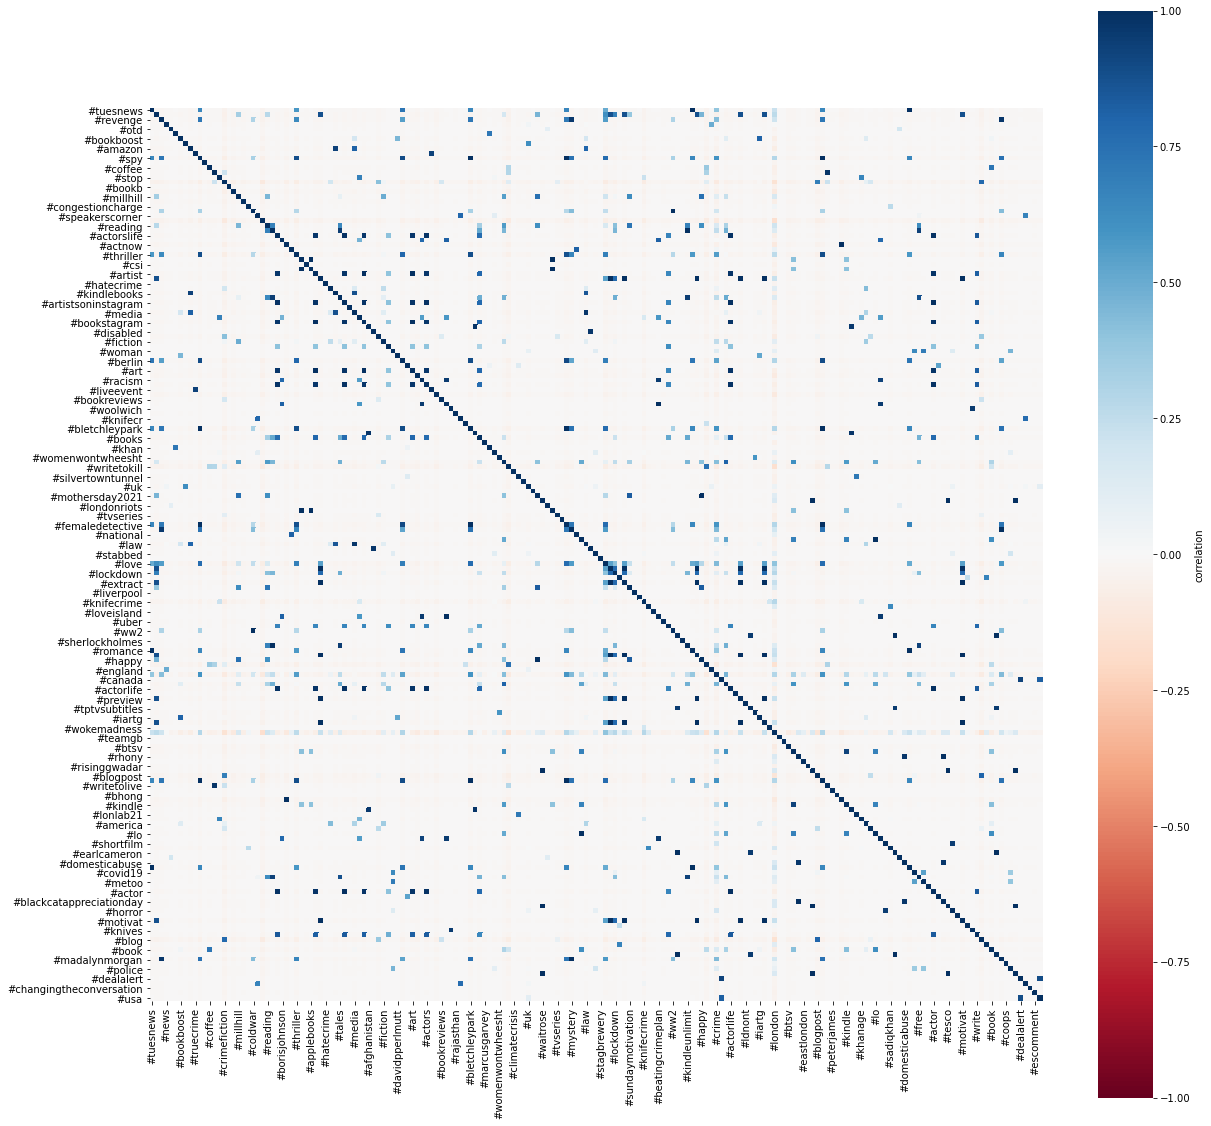

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [18]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(hashtag_matrix, 25))

Top Absolute Correlations
#shortstories        #readabook           1.0
#preview             #humor               1.0
#artist              #art                 1.0
#tale                #preview             1.0
                     #readabook           1.0
#bonarcolleano       #earlcameron         1.0
#shortstories        #tale                1.0
                     #extract             1.0
                     #preview             1.0
                     #humor               1.0
                     #motivat             1.0
#coldwar             #ww2                 1.0
#tale                #extract             1.0
#mothersday2021      #happy               1.0
#waitrose            #fulhampalaceroad    1.0
                     #tesco               1.0
                     #sainsburys          1.0
#artist              #bookstagram         1.0
#readabook           #motivat             1.0
#spy                 #bletchleypark       1.0
#extract             #readabook           1.0
#spy    

#### Comments
This is not useful yet for telling us correlations because we have too many tweets on unrelated topics and so we will review the correlations later having removed those tweets. However, this is still a useful step as it highlights good candidate topics and hashtags for deletion.

### 4.2 Treemaps for hashtags, mentions and retweets
Produce treemaps to visualise 50 most popular hashtags, mentions and retweets
- where #london or #London is not present

Then display top items in list form.

In [19]:
import squarify

def plot_popular_hashtags(df, count):
    most_popular_hashtags = df[(df.hashtag!='#London') & 
                                        (df.hashtag!='#london')][:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_hashtags['counts'], 
              label=most_popular_hashtags['hashtag'], alpha=.8 )
    plt.axis('off')
    plt.show()
    
def plot_popular_retweets(df, count):
    # now lets get the top 100 retweets into a treemap 
    most_popular_retweets = df[:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_retweets['counts'], 
              label=most_popular_retweets['retweeted'], alpha=.8 )
    plt.axis('off')
    plt.show()
    
def plot_popular_mentions(df, count):
    # now lets get the top 100 mentioned into a treemap 
    most_popular_mentioned = df[:count]

    plt.figure(figsize=(20,20))
    squarify.plot(sizes=most_popular_mentioned['counts'], 
              label=most_popular_mentioned['mentioned'], alpha=.8 )
    plt.axis('off')
    plt.show()

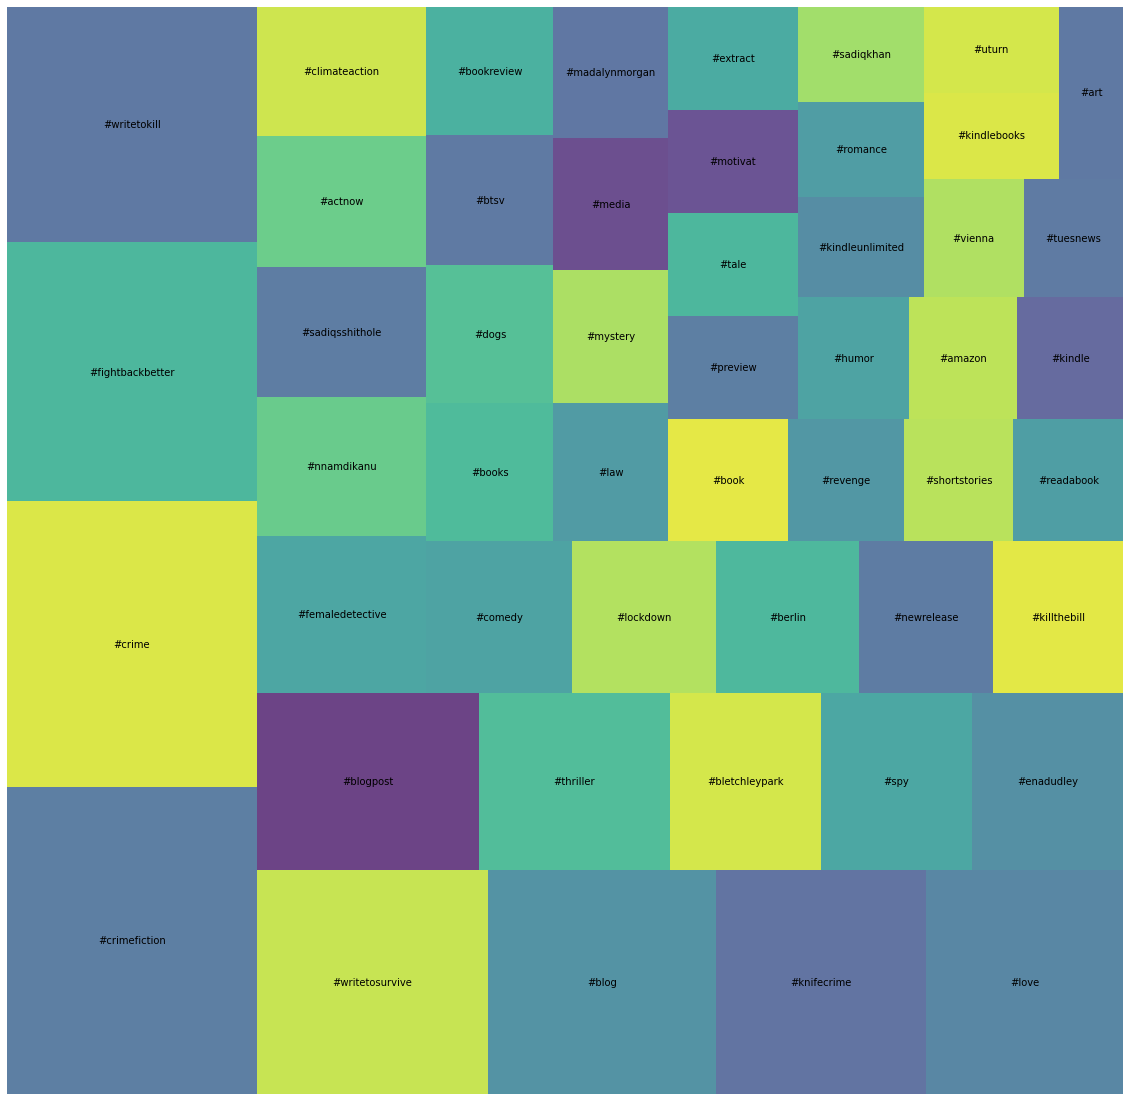

In [20]:
my_count = 50
plot_popular_hashtags(popular_hashtags, my_count)

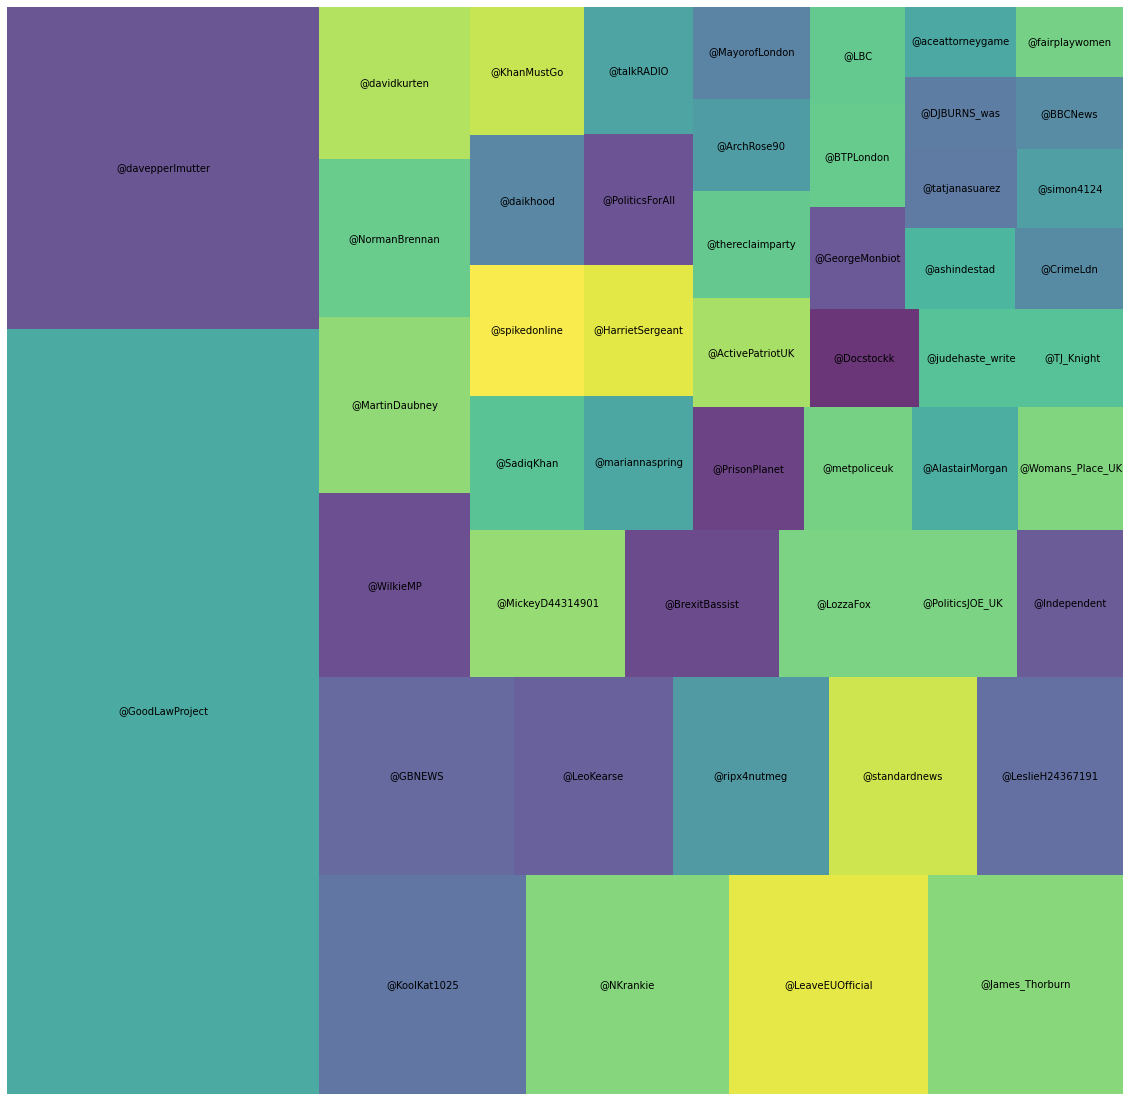

In [21]:
plot_popular_retweets(popular_retweeted, my_count)

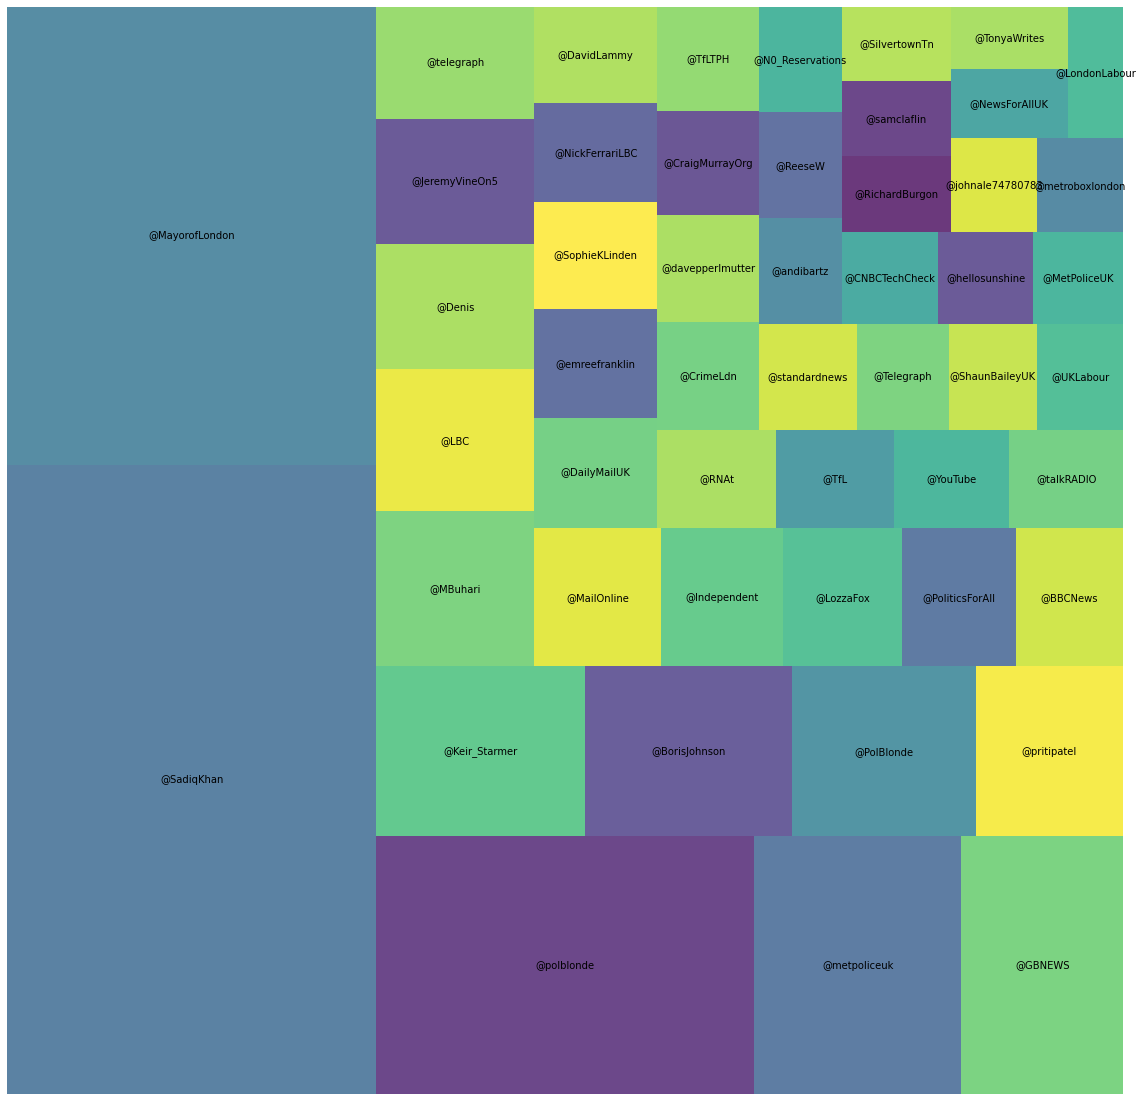

In [22]:
plot_popular_mentions(popular_mentioned, my_count)

In [23]:
popular_hashtags[:30]

,hashtag,counts
0,#london,1040
1,#crimefiction,422
2,#crime,392
3,#fightbackbetter,356
4,#writetokill,324
5,#writetosurvive,284
6,#blog,281
7,#knifecrime,258
8,#love,243
9,#blogpost,218


In [24]:
popular_mentioned[:30]

,mentioned,counts
0,@SadiqKhan,1267
1,@MayorofLondon,924
2,@polblonde,532
3,@metpoliceuk,291
4,@GBNEWS,228
5,@Keir_Starmer,194
6,@BorisJohnson,192
7,@PolBlonde,170
8,@pritipatel,137
9,@MBuhari,134


In [25]:
popular_retweeted[:30]

,retweeted,counts
0,@GoodLawProject,4787
1,@davepperlmutter,2022
2,@KoolKat1025,912
3,@NKrankie,890
4,@LeaveEUOfficial,877
5,@James_Thorburn,860
6,@GBNEWS,772
7,@LeoKearse,629
8,@ripx4nutmeg,618
9,@standardnews,586


### 4.3 Produce wordclouds
Repeat the process but this time using wordclouds for all words and also for most popular hashtags. 

In [26]:
# Create and generate word cloud images:
# create one for all words (with # symbol removed) and another with hash_tags
# code taken from VA_Lab08 (Text)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def plot_wordcloud(df, description):
    wordcloud_all = WordCloud(max_font_size=50, min_font_size=8, max_words=150, background_color="white",
                     width=800, height=400, prefer_horizontal=0.99).generate(df)
    
    # Display the generated image:
    _ = plt.figure(figsize = (16, 8))
    _ = plt.imshow(wordcloud_all, interpolation='bilinear')
    _ = plt.axis("off")
    
    description_ = "\n ----------- " + description + " ---------- \n"
    print(description_)
    plt.show()

# I want to see how many unique words
# code inspired by DataScience_Lab08
from nltk import FreqDist

def unique_words(in_text):
    text_tokens = word_tokenize(in_text)
    fdist_example = FreqDist(text_tokens)
    word_freq = dict((text_tokens, freq) for text_tokens, freq in fdist_example.items())

    return word_freq


 ----------- ALL WORDS ---------- 



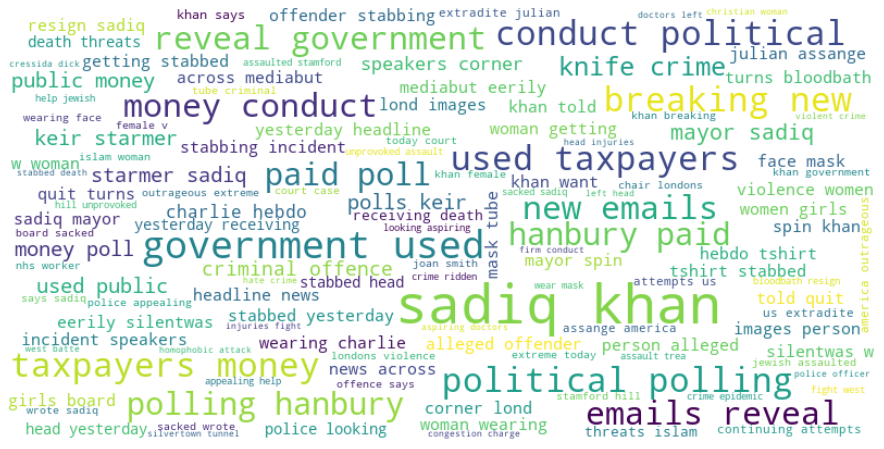


 ----------- HASH TAGS ---------- 



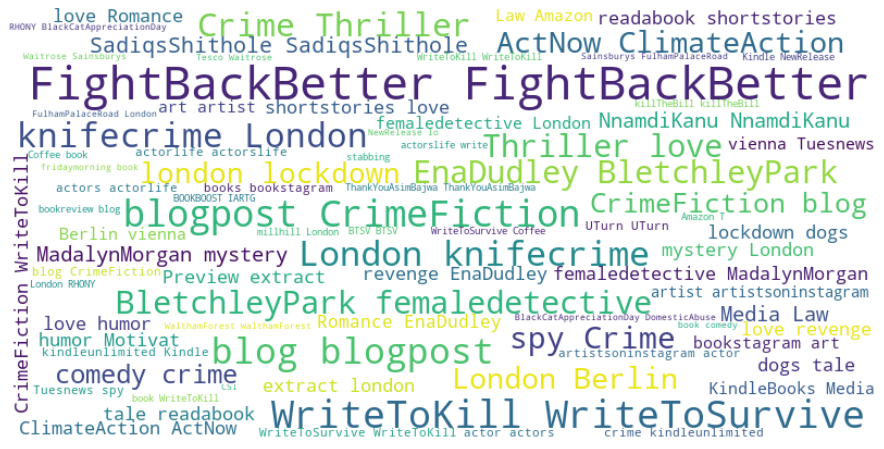

Number of all words = 16262
Number of hash_tags = 1298


In [27]:
plot_wordcloud(all_clean_words, 'ALL WORDS')
plot_wordcloud(hash_tags, 'HASH TAGS')

unique_all = unique_words(all_clean_words)
unique_hashtag = unique_words(hash_tags)

print("Number of all words = " + str(len(unique_all))) # we have 462922 unique words
print("Number of hash_tags = " + str(len(unique_hashtag))) 

### 4.4 Plot N Grams
As discussed in [1], text processing frequently entails investigating the most commonly occuring words (bag of words) and phrases (NGrams) as ways of understanding the topics being discussed within a corpus of documents. We therefore plot the most frequently occuring words, bigrams and trigrams in order to understand these topics initially as a means to identify topics we can usefully exclude from our dataset.

In [28]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#from sklearn.decomposition import TruncatedSVD
#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_k_n_gram(corpus, k=None, n=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

Loading BokehJS ...

In [29]:
def plot_ngrams(df, col_name):

    common_words = get_top_n_words(df[col_name], 25)
    df1 = pd.DataFrame(common_words, columns = [col_name, 'count'])
    df1.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 words in clean message text')

    common_bigrams = get_top_k_n_gram(df[col_name], 25,2)
    df3 = pd.DataFrame(common_bigrams, columns = [col_name , 'count'])
    df3.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 bigrams in clean message text')

    common_trigrams = get_top_k_n_gram(df[col_name], 25,3)
    df5 = pd.DataFrame(common_trigrams, columns = [col_name , 'count'])
    df5.groupby(col_name).sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title='Top 25 trigrams in clean message text')
    

In [30]:
plot_ngrams(all_tweets, 'Clean_MessageText')

### 4.5 Comments and required pruning
We want to remove tweets that aren't related to either knife or serious violent crime and to do this we review our results above and extract irrelevant tweets. This was quite a manual approach and was performed after each run. This means that certain hashtags, mentions, retweets have been identified for deletion even though they were only important in earlier runs and not as prominent in later runs.  

We categorise and explain our exclusion below. It should be noted that a a significant amount of effort needed to be expended investigating the hashtags, usernames and mentions on Twitter in order to understand the context of what they user or tweet was discussing and therefore whether we should exclude it. 

The tweets to be excluded are as follows:

#### Bigrams/words to exclude
- Sunday Igboho, Benin: is a Nigerian separatist who was arrested in the Benin republic so these tweets are not of interest for this research. 
- Daniel Morgan: The findings from an inquiry into the Metropolitan Police's handing of the Daniel Morgan murder was recently published and this report was highly critical of both the police and also the Police Commissioner's actions during the inquiry. This is slightly more difficult to exclude because we don't want to remove tweets relating to Cressida Dick because, as current Commissioner, she could also be mentioned in tweets relating to serious violent crime. Therefore in this case we just delete tweets with morgan in the text.

#### hashtags to exclude
Great timing (?) but there was a lot of discussions about crime thrillers and we wish to exlude these
- #writetokill
- #writetosurvive
- #crimefiction
- #kindle
- #thriller
- #artistsoninstagram
- #actorlife
- #actorslife
- #bookstagram
- #newrelease
- #books

SilverTown tunnel flared up with Climate crisis
- #silvertowntunnel
- #climatecrisis
- #uber
- #climateaction
- #actnow

Trans rights
- #istandwithjoansmith
- #istandwithj	

Other topics relating to international politics, congestion, novels and films
- #uber
- #nnamdikanu
- #uturn
- #fightbackbetter (anti vax)
- #thankyouasimbajwa
- #btsv (music)
- #risinggwadar
- #rajasthan

- #bonarcolleano
- #congestioncharge
- #tptvsubtitles

- #blog
- #blogpost
- #love
- #bletchleypark
- #spy
- #enadudley
- #femaledetective

- #comedy
- #lockdown
- #berlin

- #dogs
- #bookreview
- #mystery

- #blackcatappreciationday
- #marcusgarvey
- #domesticabuse
- #csi
- #masks
- #afghanistan
- #killthebill

- #disabled
- #truecrime
- #teamgb

man contaminating food
- #sainsburys
- #waitrose
- #tesco
- #fulhampalaceroad

#### retweets to exclude
Lots of retweets of authors and singers, which aren't important to us
- @Xpsilver1	- Musician, plus also activist talking about issues in Nigeria
- @AlastairMorgan	- in news, talking/writing about murder of his brother Daniel Morgan
- @davepperlmutter - thriller writer	

GoodLawProject published report on government using taxpayer money for private polling
- @GoodLawProject	

- @ripx4nutmeg - mainly about transrights
- @WilkieMP - australian MP
- @davidkurten

#### mentions to exclude
- @ParkJackh - a horror writer
- @MBuhari - president of nigeria
- @emreefranklin - actress in crime movie
- @RNAt

#### 4.5.1 Prune data

In [31]:
def prune_messages(df, exclude_hashtags, exclude_names, exclude_rt_mentions):
    df['exclude_item'] = 0
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_hashtags),case=False)] = 1
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_names),case=False)] = 1    
    df['exclude_item'][df.message_text.str.contains('|'.join(exclude_rt_mentions),case=False)] = 1
    
    df_new = df[df.exclude_item==0].copy().reset_index()
    return df_new

In [32]:
exclude_hashtags = ['#writetokill',
'#writetosurvive',
'#crimefiction',
'#kindle',
'#thriller',
'#artistsoninstagram',
'#actorlife',
'#actorslife',
'#bookstagram',
'#newrelease',
'#books',
'#silvertowntunnel',
'#climatecrisis',
'#uber',
'#climateaction',
'#actnow',
'#nnamdikanu',
'#uturn',
'#fightbackbetter',
'#thankyouasimbajwa',
'#btsv',
'#risinggwadar',
'#rajasthan',
'#bonarcolleano',
'#congestioncharge',
'#tptvsubtitles',
'#blog',
'#blogpost',
'#love',
'#bletchleypark',
'#spy',
'#enadudley',
'#femaledetective',
'#comedy',
'#lockdown',
'#berlin',
'#dogs',
'#bookreview',
'#blackcatappreciationday',
'#marcusgarvey',
'#domesticabuse',
'#sainsburys',
'#waitrose',
'#tesco',
'#fulhampalaceroad',
'#csi',
'#masks',
'#afghanistan',
'#dealalert',
'#metoo',
'#canada',
'#disabled',
'#truecrime',
'#istandwithjoansmith',
'#istandwithj',
'#killthebill',
'#teamgb',
'#mystery']

exclude_names = ['igboho', 'benin', 'daniel morgan']

exclude_rt_mentions = ['@Xpsilver1',
'@AlastairMorgan',
'@davepperlmutter',
'@GoodLawProject',
'@ripx4nutmeg',
'@WilkieMP',
'@davidkurten',
'@ParkJackh',
'@MBuhari',
'@emreefranklin',
'@RNAt']

all_tweet_cleaned_raw = prune_messages(all_tweets, exclude_hashtags, exclude_names, exclude_rt_mentions)

print("number of rows before pruning: {:,}, number of rows after: {:,}".format(all_tweets.shape[0],
                                                                              all_tweet_cleaned_raw.shape[0]))


number of rows before pruning: 52,201, number of rows after: 41,706


#### Comments
We reduced the dataset by 20% and so there was a lot of noise. This was as expected because 'sadiq AND khan' was one of our search terms and it was intended for this term to be more generic in case it helped us serendipitously identify crime related tweets.

#### 4.5.2 Recreate pruned dataset
I need to regenerate the message text, hashtags, retweets etc based on the pruned dataframe
- First I need to drop these columns from the new dataframe

In [33]:
copy_fields = ['tweet_id',
              'tweet_date',
              'tweeter_id',
              'tweeter_user_name',
              'tweeter_screen_name',
              'tweeter_location',
              'message_text',
              'in_reply_to_user_screen_name',
              'quote_tweet_screen_name',
              'favourite_count',
              'retweet_count',
               'is_retweet',
              'extract_run_date',
              'retrieved_using_search_term']
all_tweet_cleaned = all_tweet_cleaned_raw[copy_fields].copy().reset_index()

In [34]:
all_tweet_cleaned = get_rt_mentions_hash(all_tweet_cleaned, 'message_text')
all_tweet_cleaned, hash_tags_cleaned, all_clean_words_cleaned = get_clean_lemmatized(all_tweet_cleaned, 'message_text')

#### 4.5.3. Analyse pruned data

In [35]:
popular_hashtags_cleaned, hashtag_matrix_cleaned = get_popular_hashtags(all_tweet_cleaned, 10)
popular_retweeted_cleaned = get_popular_retweets(all_tweet_cleaned)
popular_mentioned_cleaned = get_popular_mentioned(all_tweet_cleaned)

<Figure size 1440x1440 with 0 Axes>

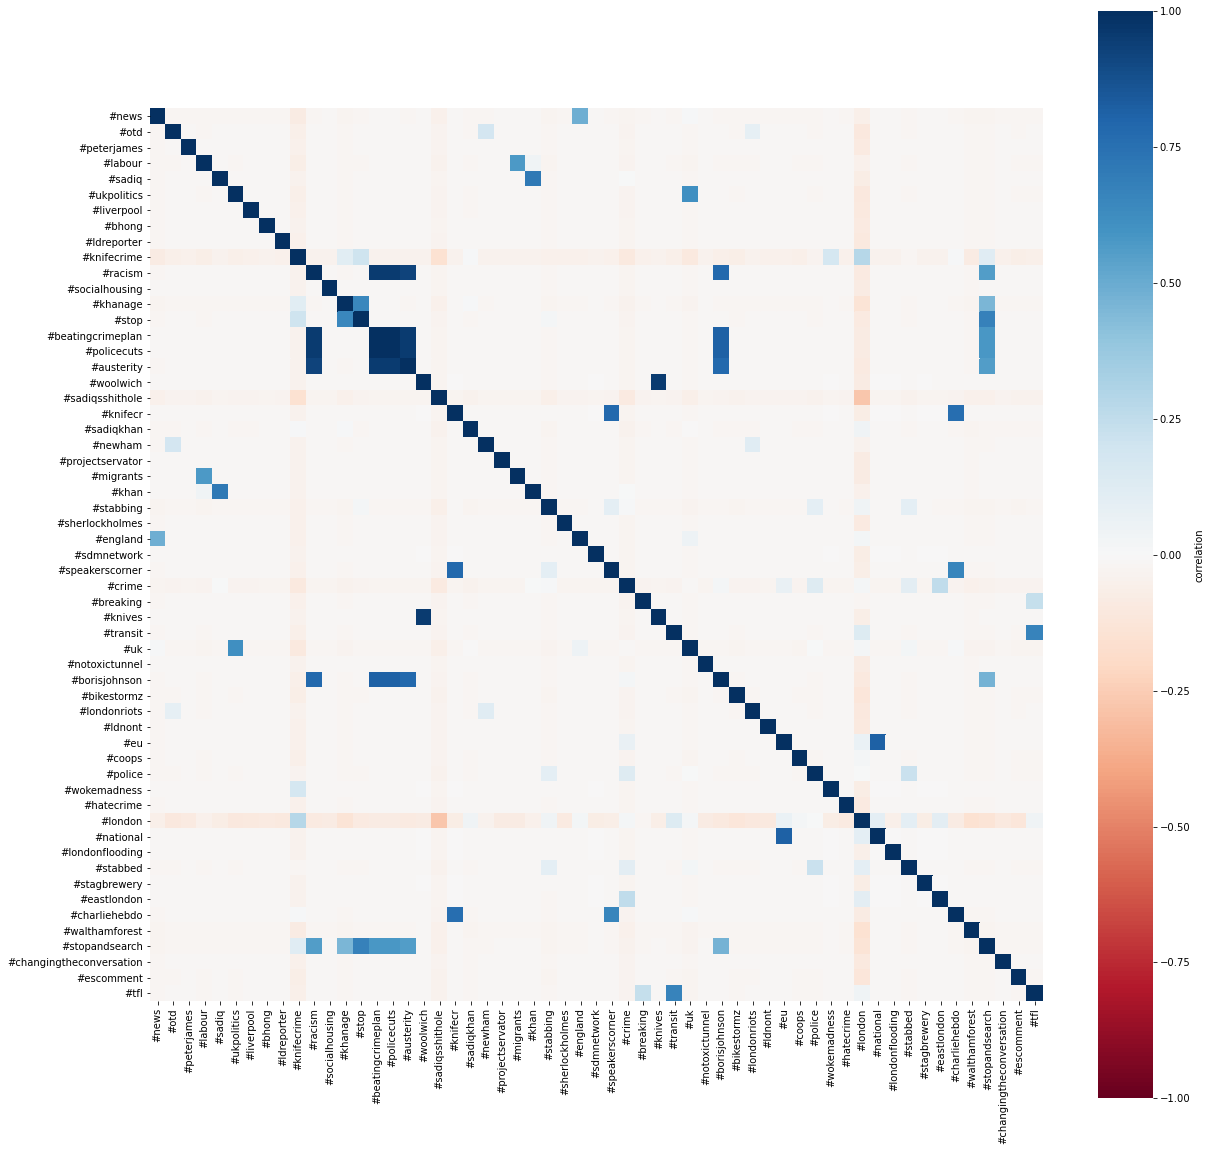

In [36]:
correlations = hashtag_matrix_cleaned.corr()
# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [37]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(hashtag_matrix_cleaned, 25))

Top Absolute Correlations
#beatingcrimeplan  #policecuts          1.000000
                   #austerity           0.960417
#racism            #beatingcrimeplan    0.960417
                   #policecuts          0.960417
#policecuts        #austerity           0.960417
#woolwich          #knives              0.957077
#racism            #austerity           0.922344
#eu                #national            0.815002
#policecuts        #borisjohnson        0.814700
#beatingcrimeplan  #borisjohnson        0.814700
#knifecr           #speakerscorner      0.788833
#austerity         #borisjohnson        0.782161
#racism            #borisjohnson        0.782161
#knifecr           #charliehebdo        0.764999
#sadiq             #khan                0.718024
#stop              #stopandsearch       0.672014
#transit           #tfl                 0.664667
#speakerscorner    #charliehebdo        0.662940
#khanage           #stop                0.653053
#ukpolitics        #uk                  0.6

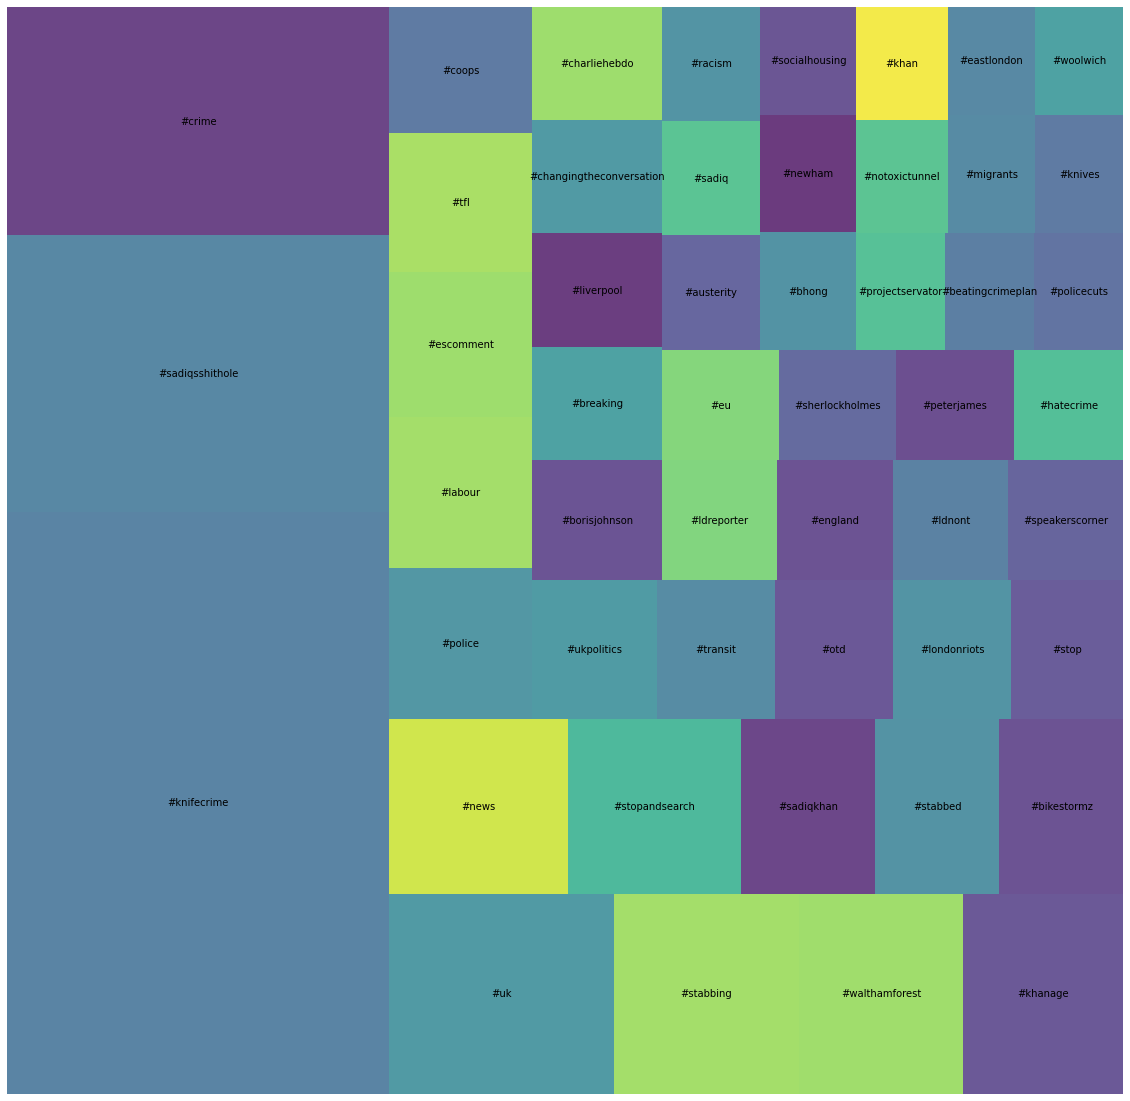

In [38]:
plot_popular_hashtags(popular_hashtags_cleaned, my_count)

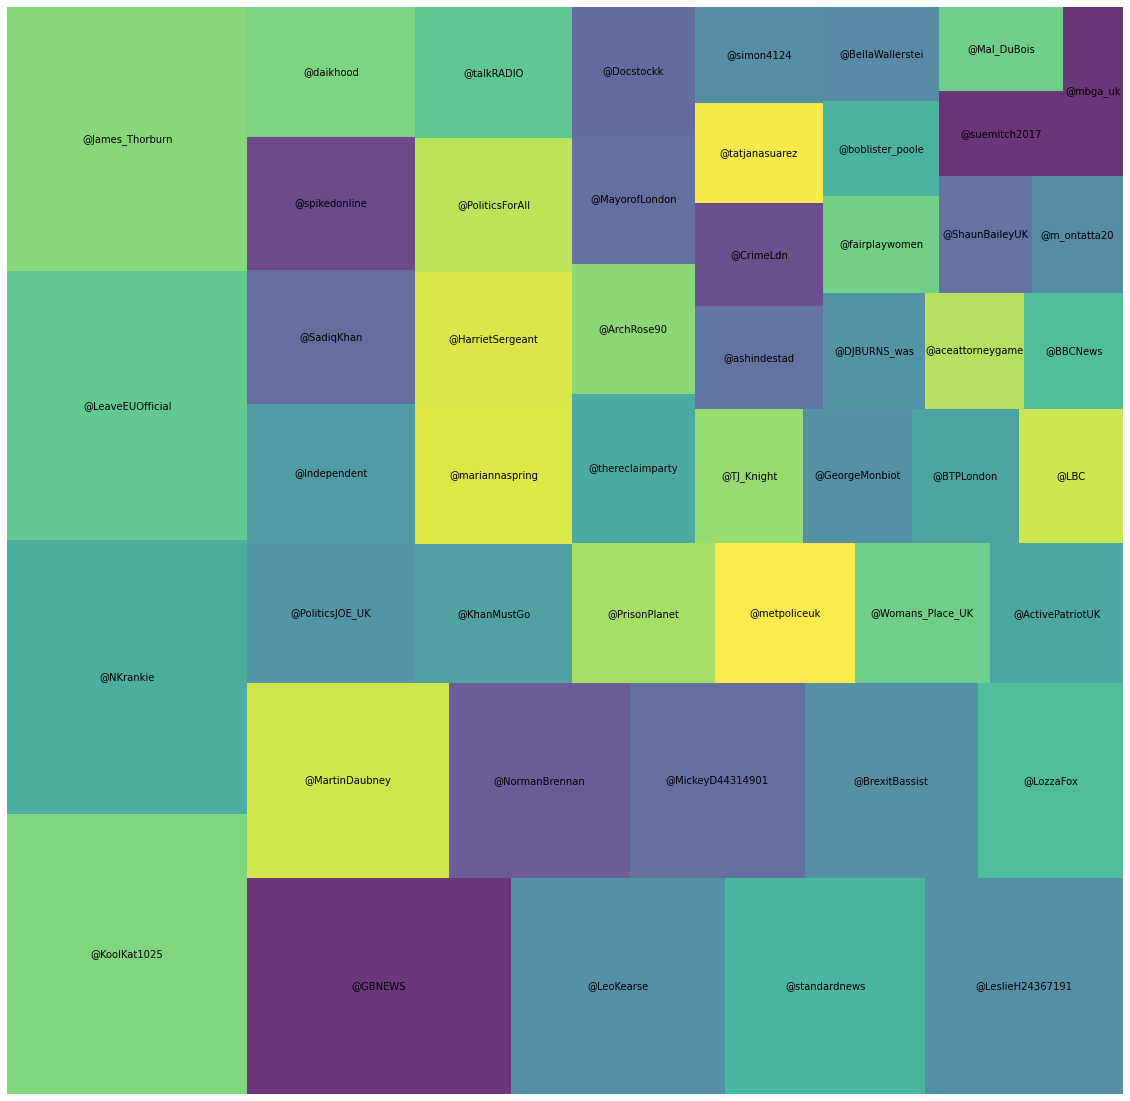

In [39]:
plot_popular_retweets(popular_retweeted_cleaned, my_count)

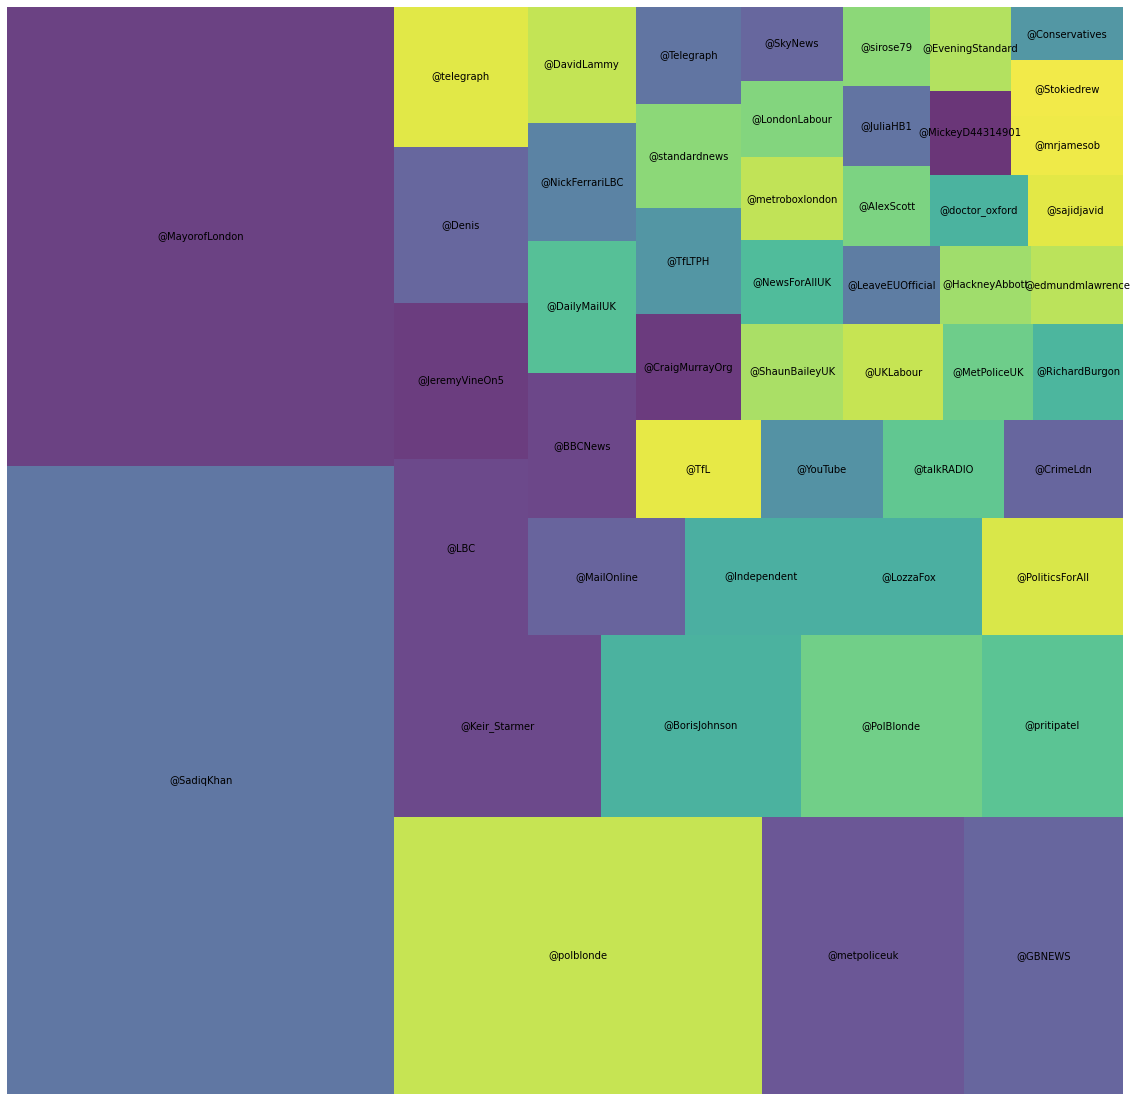

In [40]:
plot_popular_mentions(popular_mentioned_cleaned, my_count)

In [41]:
popular_hashtags_cleaned[:30]

,hashtag,counts
0,#london,603
1,#knifecrime,257
2,#sadiqsshithole,122
3,#crime,101
4,#uk,52
5,#stabbing,43
6,#walthamforest,38
7,#khanage,37
8,#news,36
9,#stopandsearch,35



 ----------- ALL WORDS ---------- 



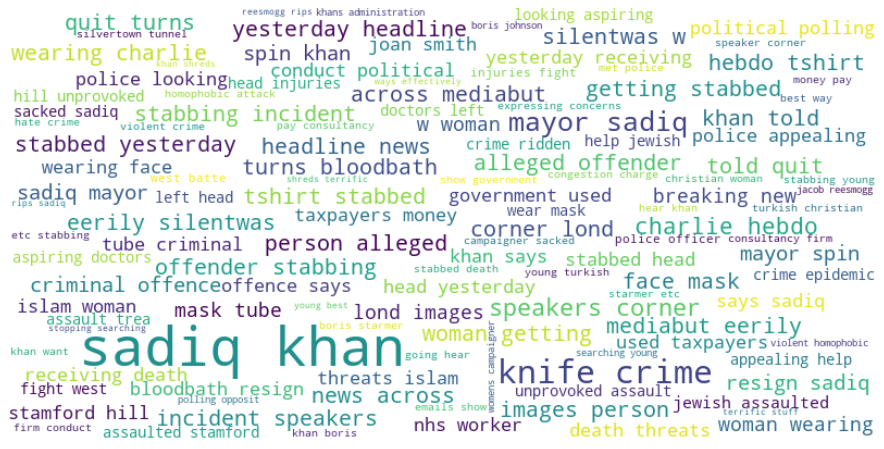


 ----------- HASH TAGS ---------- 



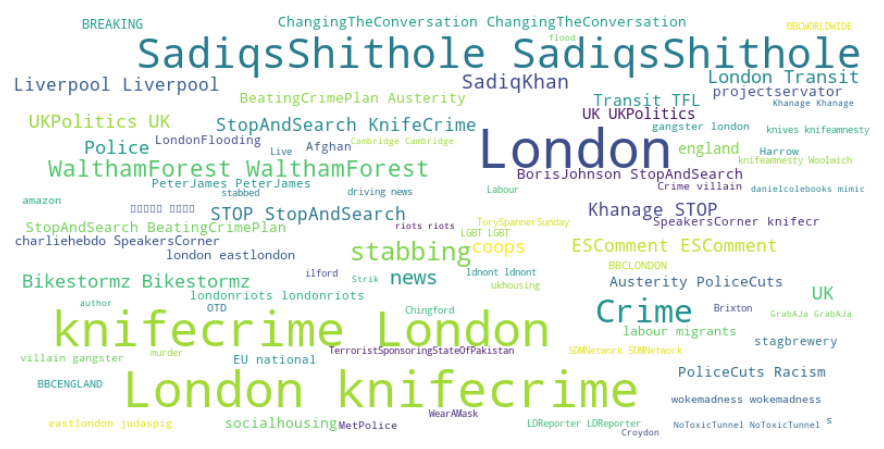

In [42]:
plot_wordcloud(all_clean_words_cleaned, 'ALL WORDS')
plot_wordcloud(hash_tags_cleaned, 'HASH TAGS')

unique_all = unique_words(all_clean_words_cleaned)
unique_hashtag = unique_words(hash_tags_cleaned)

In [43]:
print("Number of all words = " + str(len(unique_all))) # we have 462922 unique words
print("Number of hash_tags = " + str(len(unique_hashtag))) 

plot_ngrams(all_tweet_cleaned, 'Clean_MessageText')


Number of all words = 15932
Number of hash_tags = 1053


### Comments on pruned dataset
The words, ngrams and top hashtags, mentions and tweets are now far more relevant to crime in London. IN terms of which methods were most useful in identifying topics to exclude, we believe the printed lists of hashtags and top correlations were most helpful, followed by the bag of words and ngrams. The word cloud and treemaps were useful mainly as a sense check once we had pruned the dataset.

## 5. Analyse general statistics
We now have a dataset we can use in downstream processing but first we want to find out some general statistics about our dataset. These include:
- Number of tweets and number of unique users
- Where tweets originated
- Tweet volumes over time

### 5.1 Number of tweets, number of unique users

In [44]:
tweet_num = all_tweet_cleaned.shape[0]
user_num = all_tweet_cleaned.tweeter_screen_name.nunique()

print("Total number of tweets in cleaned dataset: {:,}, total number of unique users: {:,}".format(tweet_num, 
                                                                                                  user_num))

Total number of tweets in cleaned dataset: 41,706, total number of unique users: 23,857


#### Comments
About 2 tweets per person if we averaged, but we will drill into this in far more detail in later notebooks.

### 5.2 Location

In [45]:
unknown_location = all_tweet_cleaned['tweeter_location'][all_tweet_cleaned['tweeter_location'].str.contains('unknown')].count()
not_london = all_tweet_cleaned['tweeter_location'][(~all_tweet_cleaned['tweeter_location'].str.contains('London')) &
                                           (~all_tweet_cleaned['tweeter_location'].str.contains('unknown'))].count()

count_london = all_tweet_cleaned['tweeter_location'][all_tweet_cleaned['tweeter_location'].str.contains('London')].count()

unique_london = all_tweet_cleaned['tweeter_location'][all_tweet_cleaned['tweeter_location'].str.contains('London')].unique()

print('Number of tweets where location is not known is {:,}, while number of tweets originating outside London is {:,}'.format(unknown_location, not_london))
print('Number of tweets where location is London is {:,}, and these unique locations are as follows\n'.format(count_london))

unique_london

Number of tweets where location is not known is 14,567, while number of tweets originating outside London is 20,824
Number of tweets where location is London is 6,315, and these unique locations are as follows



array(['London', 'Bexleyheath London England',
       'Chigwell London/Essex England', 'Sutton, London',
       'London, England', 'London & Oslo', 'Westminster, London',
       'South West England, ex London.', 'London ', 'London, UK',
       'East London.', 'London / New York / LA', 'SE London, Europe',
       'London E3', 'London, wish I was in Kerry',
       'London, United Kingdom', 'London, E14 2BG', 'Central London, UK',
       'Bromley, London', 'Ilford, London', 'Too close to London',
       'London, Chelmsford England, UK', 'Originally East London.',
       'South London', 'East London, UK', 'Camden Town, London',
       'Burdett Estate, London, E14', "TW8, It's a London thing",
       'Croydon, London',
       'London, England.                     Retweets/shares are not endorsements.',
       'London, England, UK', 'London Village, England', 'SE London',
       'East London', 'Ealing, London', 'Derry & London',
       'Enfield, London', 'Hammersmith, London', 'Brent, London

#### Comments
Earlier we removed the geo fields from the Twitter data because they weren't populated and it appears that the location field is more free format rather than a field we can use to formally identify where tweets located. In addition, of the approximately 40,000 tweets, only 6,000 have been tagged as originating in London. It's worth investigating this further.

In [46]:
tweet_locations = all_tweet_cleaned.groupby(['tweeter_location'], sort = False).count().reset_index()
tweet_locations = tweet_locations[['tweeter_location', 'tweet_id']]
tweet_locations.rename(columns = {'tweet_id':'count'}, inplace = True)

tweet_locations = tweet_locations.sort_values(['count'], ascending=[False])
    
tweet_locations = tweet_locations[tweet_locations.tweeter_location!='unknown'][:25]

In [47]:
import altair as alt
alt.data_transformers.disable_max_rows()

tweet_by_location_bar = alt.Chart(tweet_locations, title='locations with highest tweet volumes (unknowns excluded)').mark_bar(opacity=0.6, 
                                                                                                          color='firebrick', 
                                                                                                          size=20).encode(
    x=alt.X('count:Q', axis=None),
    y=alt.Y('tweeter_location:N', axis=alt.Axis(title='', ticks=False), sort='-x'),  
)

tweet_by_location_text = alt.Chart(tweet_locations).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dx=20 
).encode(
    x=alt.X('count:Q', axis=None),
    y=alt.Y('tweeter_location:N', axis=None, sort='-x'),   
    text=alt.Text('count:Q', format=',')
)

(tweet_by_location_bar + tweet_by_location_text).properties(
    width=600,
    height=600
).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

DataTransformerRegistry.enable('default')

alt.LayerChart(...)

#### Comments
The majority of tweets do originate from a Tweeter who identifies as living in London but it's also interesting to see that a large number of people from outside of London are tweeting about crime in London.

### 5.3 Time

In [48]:
from datetime import timedelta
all_tweet_cleaned['tweet_date_dt'] = pd.to_datetime(all_tweet_cleaned['tweet_date'])
all_tweet_cleaned['time_bins_12h'] = all_tweet_cleaned['tweet_date_dt'].dt.floor('12h')
all_tweet_cleaned['day_bins'] = all_tweet_cleaned['tweet_date_dt'].dt.floor('24h')

all_tweets_time = all_tweet_cleaned.groupby(["time_bins_12h"]).apply(lambda x: x['time_bins_12h'].count()).reset_index()
all_tweets_time.rename(columns = {0:'count'}, inplace = True)

all_tweets_day = all_tweet_cleaned.groupby(["day_bins"]).apply(lambda x: x['day_bins'].count()).reset_index()
all_tweets_day.rename(columns = {0:'count'}, inplace = True)

In [49]:
tweet_by_days_bar = alt.Chart(all_tweets_day, title='Tweet volume by day').mark_bar(opacity=0.6, color='firebrick', size=15).encode(
    x=alt.X('monthdate(day_bins):O', axis=alt.Axis(title='', ticks=False)),
    y=alt.Y('count:Q', axis=None),  
)

tweet_by_days_text = alt.Chart(all_tweets_day).mark_text(
    align='center',
    baseline='middle',
    color='black',
    dy=-8 
).encode(
    x=alt.X('monthdate(day_bins):O', axis=alt.Axis(ticks=False, format=("%b %d"))),
    y=alt.Y('count:Q', axis=alt.Axis(title='count', ticks=False)),  
    text=alt.Text('count:Q', format=',')
)

(tweet_by_days_bar + tweet_by_days_text).properties(
    width=900,
    height=300
).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.LayerChart(...)

In [50]:
term_volumes_by_day = all_tweet_cleaned.groupby(['day_bins', 'retrieved_using_search_term'], sort = False).count().reset_index()
term_volumes_by_day = term_volumes_by_day[['day_bins', 'retrieved_using_search_term', 'tweet_id']]
term_volumes_by_day.rename(columns = {'tweet_id':'count'}, inplace = True)

term_volumes_by_day = term_volumes_by_day.sort_values(['count'], ascending=[False])
    
term_volumes_by_day = term_volumes_by_day[:100]
term_volumes_by_day[:20]

,day_bins,retrieved_using_search_term,count
127,2021-08-05,sadiq AND khan,1894
242,2021-08-19,sadiq AND khan,1491
70,2021-07-29,sadiq AND khan,1223
126,2021-08-06,sadiq AND khan,1159
72,2021-07-27,sadiq AND khan,1115
63,2021-07-26,London AND stabbing,1014
71,2021-07-28,sadiq AND khan,1011
280,2021-08-23,London AND crime,963
241,2021-08-20,sadiq AND khan,927
74,2021-07-25,sadiq AND khan,819


In [51]:
alt.Chart(term_volumes_by_day, title='Tweet volumes by search term by day').mark_rect().encode(   
    x=alt.X('monthdate(day_bins):O', axis=alt.Axis(title='', ticks=False)),    
    y=alt.Y('retrieved_using_search_term:N', axis=alt.Axis(title='', ticks=False)),    
    color=alt.Color('count:Q')
).properties(
    width=760,
    height=140
).configure_axis(
    grid=False,
    domain=False
).configure_view(
    strokeWidth=0)

alt.Chart(...)

## Tweet by day comments
The volume of tweets increases significantly when we were able to include tweets returned by the search term 'sadiq AND khan'and this is most clearly shown by both the increase in tweets around 26-28 July, 5-6 August and also the distinct drop in tweet volumes between August 7-12 and August 22 onwards. It is also interesting that we got a peak in tweets about London stabbing on 26/27 August and many of these related to the stabbing of a woman wearing a Charlie Hebdo t-shirt in Hyde Park corner, which received considerable media attention (this can be easily visualised in the Ngram plots) 

## 6. Produce extract file for use in downstream hashtag, user group and tweet classification analyses

In [52]:
outputfile_str = "./DataSources/TwitterData/cleaned_tweets.csv"

all_tweet_cleaned.to_csv(outputfile_str, index=False)

In [53]:
all_tweets_df_new = pd.read_csv(outputfile_str)
print(all_tweets_df_new.shape)
all_tweets_df_new.head()

(41706, 26)


,index,tweet_id,tweet_date,tweeter_id,tweeter_user_name,tweeter_screen_name,tweeter_location,message_text,in_reply_to_user_screen_name,quote_tweet_screen_name,favourite_count,retweet_count,is_retweet,extract_run_date,retrieved_using_search_term,retweeted,mentioned,hashtags,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Clean_MessageText,tweet_date_dt,time_bins_12h,day_bins
0,0,1420355029081395203,2021-07-28 12:06:42,865262041103302656,Chris Myers,myerschrismyer1,Richmond North Yorkshire,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 12:06:42,2021-07-28 12:00:00,2021-07-28 00:00:00
1,1,1420354120041615364,2021-07-28 12:03:05,229645453,Emily Sheffield,emilysheffield,London,RT @NaheedMajeed: Spot on @standardnews With L...,NaN,NaN,0,2,Y,20210728,London AND knife AND crime,['@NaheedMajeed'],['@standardnews'],[],Spot on With London on track to break record...,"['spot', 'on', 'with', 'london', 'on', 'track'...","['spot', 'track', 'break', 'record', 'teenage'...","['spot', 'track', 'break', 'record', 'teenage'...",spot track break record teenage murdersstop se...,2021-07-28 12:03:05,2021-07-28 12:00:00,2021-07-28 00:00:00
2,2,1420351785156366337,2021-07-28 11:53:49,2843896642,Basilewitch,basilewitch,France,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:53:49,2021-07-28 00:00:00,2021-07-28 00:00:00
3,3,1420350419449094148,2021-07-28 11:48:23,556315551,Dean Cowcher,DeanCowcher,Bexleyheath London England,RT @LeslieH24367191: 'Do better!' Boris Johnso...,NaN,NaN,0,40,Y,20210728,London AND knife AND crime,['@LeslieH24367191'],[],[],Do better Boris Johnson issues scathing respo...,"['do', 'better', 'boris', 'johnson', 'issues',...","['better', 'boris', 'johnson', 'issues', 'scat...","['good', 'boris', 'johnson', 'issues', 'scathi...",good boris johnson issues scathing response sa...,2021-07-28 11:48:23,2021-07-28 00:00:00,2021-07-28 00:00:00
4,4,1420349615954669574,2021-07-28 11:45:11,1267062754915090434,Alfiecat,sonya_annie,unknown,RT @Short2Cjs: Boris today speaking to Nick Fe...,NaN,NaN,0,4,Y,20210728,London AND knife AND crime,['@Short2Cjs'],[],[],Boris today speaking to Nick Ferrari about Kh...,"['boris', 'today', 'speaking', 'to', 'nick', '...","['boris', 'today', 'speaking', 'nick', 'ferrar...","['boris', 'today', 'speaking', 'nick', 'ferrar...",boris today speaking nick ferrari khan … done ...,2021-07-28 11:45:11,2021-07-28 00:00:00,2021-07-28 00:00:00


# Appendix A - References
- [1] Bekkerman, R. and Allan, J., 2004. Using bigrams in text categorization (pp. 1-10). Technical Report IR-408, Center of Intelligent Information Retrieval, UMass Amherst.